# Housing Price Prediction

Competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview  

This is the notebook for my entry to the housing prices prediction competition on Kaggle.
As of right now, my best submission has a best score (root mean logarithmic error) of 0.15797 and 
am 3301 on the leaderboard.

My next steps are to try and use sklearn's builtin feature_selection funtions and PCA to see if these can improve the model's accuracy compared to my intuition.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

In [2]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [3]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# replace current index with index from data frame
train_data.index = train_data["Id"]
train_data = train_data.drop("Id", axis=1)

test_data.index = test_data["Id"]
test_data = test_data.drop("Id", axis=1)

In [6]:
train_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# describe the numeric columns in data 
train_data.describe(include=np.number)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [227]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [8]:
# manually selected columns that don't seem to affect SalePrice very much, so we drop them
to_drop = ["YrSold", "MoSold", "PoolArea", "KitchenAbvGr", "LowQualFinSF", "BsmtHalfBath",
           "BsmtFullBath", "BsmtFinSF2", "MSSubClass", "Utilities", "Condition2",
          "GarageYrBlt", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "MiscVal",
          "BedroomAbvGr", "HalfBath", "LotArea"]
x_train = train_data.drop(to_drop, axis=1)
x_test = test_data.drop(to_drop, axis=1)

x_train = x_train.drop("SalePrice", axis=1)
y_train = train_data["SalePrice"]

# cols identified as not having enough values to be considered
sparse_cols = ["Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
x_train = x_train.drop(sparse_cols, axis=1)
x_test = x_test.drop(sparse_cols, axis=1)

In [9]:
# create a separate training set to establish baseline based on numerical cols only
num_x_train = x_train.select_dtypes(include=[np.number])
num_x_test = x_test.select_dtypes(include=[np.number])

# fill in NaN values with mean for each col
num_x_train = num_x_train.fillna(value=num_x_train.mean())
num_x_test = num_x_test.fillna(value=num_x_test.mean())

In [406]:
num_x_train.columns

Index(['LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')

In [464]:
test_x = num_x_train.drop("BsmtUnfSF", axis=1)
x = num_x_test.drop("BsmtUnfSF", axis=1)

In [410]:
test_x.columns

Index(['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')

In [407]:
y = train_data["SalePrice"]

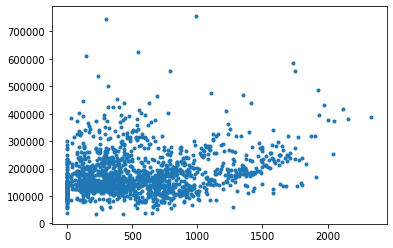

In [456]:
plt.plot(train_data["BsmtUnfSF"], y, ".")

## Categorical Columns

Here, we begin to add some of the categorical cols to the training data to see if any of these features will improve the train and test data accuracy. Remember, since these are categorical columns, their values will need to be converted to numerical values before they can be used for training. 

In [210]:
cat_cols = train_data.select_dtypes(exclude=np.number).columns
len(cat_cols)
cat_cols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [475]:
# filtering for categorical cols without any null values
no_null = [col for col in cat_cols if not train_data[col].isnull().any()]
np.array(no_null)

array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'], dtype='<U13')

In [478]:
# finding columns with null values for fillna later
has_null = [col for col in cat_cols if train_data[col].isnull().any()]
np.array(has_null)

array(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='<U11')

In [259]:
# fill in NaN values with most common occurrence 
train_data[has_null] = train_data[has_null].fillna(train_data[has_null].mode().iloc[0])

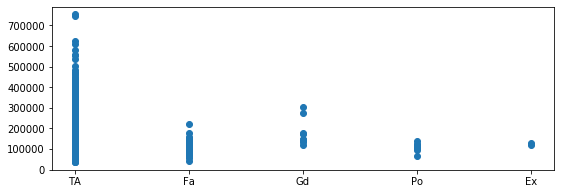

In [398]:
# plot the relationship between a column and SalePrice
plt.figure(figsize=(9, 3))
col_name = "GarageCond"
plt.plot(train_data[col_name], y_train, 'o')

In [399]:
# this loop helps identify the mean of each unique value in the col and how many
# data points per unique val
for val in train_data[col_name].unique():
    print("Val: %s" % val)
    mean = y_train[train_data[col_name] == val].mean()
    print(mean)
#     print(x_train[col_name].var())
    print(len(train_data[train_data[col_name] == val]))
    print()

Val: TA
183017.18905472636
1407

Val: Fa
114654.02857142857
35

Val: Gd
179930.0
9

Val: Po
108500.0
7

Val: Ex
124000.0
2



In [400]:
# append col to numerical features we filtered previously
x_train = num_x_train.join(train_data[col_name])
x_test = num_x_test.join(test_data[col_name])

In [401]:
# loop through unique vals for col and assign num val to each
for i, val in enumerate(x_train[col_name].unique()):
    x_train.loc[x_train[col_name] == val, col_name] = i
    x_test.loc[x_test[col_name] == val, col_name] = i

There are times where having too many unique discrete values can affect the accuracy of a model. Below are a few of my attempts to separate feature values that had a higher average SalePrice in an attempt to increase the accuracy of my model. These all failed, however. 

In [285]:
# col_name = "MasVnrType"
# x_train.loc[(x_train[col_name] == "BrkFace") | (x_train[col_name] == "Stone"), col_name] = 1
# x_train.loc[x_train[col_name] != 1, col_name] = 0

In [160]:
# col_name = "CentralAir"
# x_train.loc[x_train[col_name] == "Y", col_name] = 1
# x_train.loc[x_train[col_name] == "N", col_name] = 0

In [341]:
# col_name = "Foundation"
# x_train.loc[(x_train[col_name] == "PConc") | (x_train[col_name] == "Wood") | (x_train[col_name] == "Stone"), col_name] = 1
# x_train.loc[x_train[col_name] != 1, col_name] = 0

In [332]:
# col_name = "RoofMatl"
# x_train.loc[(x_train[col_name] == "WdShngl") | (x_train[col_name] == "WdShake") | (x_train[col_name] == "Membran"), col_name] = 1
# x_train.loc[x_train[col_name] != 1, col_name] = 0

In [322]:
# col_name = "BldgType"
# x_train.loc[(x_train[col_name] == "1Fam") | (x_train[col_name] == "TwnhsE"), col_name] = 1
# x_train.loc[x_train[col_name] != 1, col_name] = 0

# x_test.loc[(x_test[col_name] == "1Fam") | (x_test[col_name] == "TwnhsE"), col_name] = 1
# x_test.loc[(x_test[col_name] != "1Fam") & (x_test[col_name] != "TwnhsE"), col_name] = 0

In [501]:
# col_name = "Neighborhood"
# for val in x_train[col_name].unique():
#     if val in low_avg_nbh:
#         x_train.loc[x_train[col_name] == val, col_name] = 0
#     else:
#         x_train.loc[x_train[col_name] == val, col_name] = 1

In [312]:
# col_name = "LandContour"
# x_train.loc[x_train[col_name] == "Bnk", col_name] = 0
# x_train.loc[x_train[col_name] != 0, col_name] = 1

In [304]:
# col_name = "LotShape"
# x_train.loc[x_train[col_name] == "Reg", col_name] = 0
# x_train.loc[x_train[col_name] != 0, col_name] = 1

In [296]:
# col_name = "MSZoning"
# x_train.loc[x_train[col_name] == "RL", col_name] = 4
# x_train.loc[x_train[col_name] == "RM", col_name] = 3
# x_train.loc[x_train[col_name] == "C (all)", col_name] = 2
# x_train.loc[x_train[col_name] == "FV", col_name] = 1
# x_train.loc[x_train[col_name] == "RH", col_name] = 0

# x_train.loc[(x_train[col_name] == "RL") | (x_train[col_name] == "FV"), col_name] = 1
# x_train.loc[x_train[col_name] != 1, col_name] = 0

# x_test.loc[x_test[col_name]== "RL"] = 4
# x_test.loc[x_test[col_name] == "RM"] = 3
# x_test.loc[x_test[col_name] == "C (all)"] = 2
# x_test.loc[x_test[col_name] == "FV"] = 1
# x_test.loc[x_test[col_name] == "RH"] = 0

## Model Selection and Training

This is where I create a model and try to identify more features to see if the accuracy will improve. In the code below, you will see I implemented a function to check if the accuracy has increased from this run to the next. For categorical feature testing, I used the training data from the numerical features as a baseline to see if adding this categorical feature would increase the accuracy of the model. I checked the accuracy via Mean Squared Log Error (as it is in the Kaggle competition) and tested it against Support Vector Regression, Linear Regression, K Neighbors Regression, Decision Tree Regressor and Random Forest Regressor. 

From this experiment, I've found that the model with the best training accuracy is the Decision Tree Regressor, however, the Random Forest Regressor tended to do better on the validation set so I went with the RF Regressor in my Kaggle submissions. 

In [16]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

In [17]:
def acc_delta (prev_scores, new_scores):
    
    """
    function_name: acc_delta
    purpose: print the difference in scores (acc or err) btwn prev run and this run
    params: prev_scores - dict containing model->acc (or err) mappings
    returns: dict containing differences in scores or err
    """
    
    delta = {}
    if prev_scores.keys() != new_scores.keys():
        print ("Keys don't match!")
        raise
    
    for key in prev_scores.keys():
        
        # sign matters so we want delta from this run and last run
        # whether sign is good or bad depends on metric (acc or err)
        delta[key] = new_scores[key] - prev_scores[key]
        
    return delta
    

In [465]:
# normalize all data points by L2 on feature
norm_x_train = normalize(test_x, axis=0)
norm_x_test = normalize(x, axis=0)

# train, validation split
norm_x_train, x_val, norm_y_train, y_val = train_test_split(norm_x_train, y_train)

In [466]:
models = [LinearRegression(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor()]
if train_scores:
    prev_train_scores = train_scores
if scores:
    prev_scores = scores
regs = {}
train_scores = {}
scores = {}
reg_name_pat = "\<class \'.*\.(\w+)\'\>"
for model in models:
    model.fit(norm_x_train, norm_y_train)
    model_name = re.search(reg_name_pat, str(model.__class__)).group(1)
    train_scores[model_name] = np.abs(model.score(norm_x_train, norm_y_train))
    pred = model.predict(x_val)
    regs[model_name] = model
    scores[model_name] = mean_squared_log_error(y_val, np.abs(pred))
    
train_scores

/Users/davidlin/Library/Python/3.7/lib/python/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/davidlin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'LinearRegression': 0.830973090792447,
 'SVR': 0.055776153762902236,
 'KNeighborsRegressor': 0.8222839016384208,
 'DecisionTreeRegressor': 0.9999905587355703,
 'RandomForestRegressor': 0.971259973707231}

## Delta between curr test run and num_cols

In [467]:
# metric for train_scores is R^2, which we want to be as close to 1 as possible
# therefore, a negative value would indicate poorer performance
acc_delta(num_train_scores, train_scores)

{'LinearRegression': 0.04936110394023441,
 'SVR': 0.10364026267436643,
 'KNeighborsRegressor': 0.005102862780833051,
 'DecisionTreeRegressor': -9.135461753739804e-07,
 'RandomForestRegressor': 0.0031867616928192843}

In [468]:
# the metric to measure val score is error, so a neg value indicates an improvement
acc_delta(num_scores, scores)

{'LinearRegression': -0.0123379319887469,
 'SVR': 0.002250879559426211,
 'KNeighborsRegressor': 0.009804362252400577,
 'DecisionTreeRegressor': 0.0011252682858389831,
 'RandomForestRegressor': 0.00622430810520189}

## Delta between last test run and curr

In [380]:
# metric for train_scores is R^2, which we want to be as close to 1 as possible
# therefore, a negative value would indicate poorer performance
acc_delta(prev_train_scores, train_scores)

{'LinearRegression': -1.4740733129650317e+20,
 'SVR': 0.005440909657944408,
 'KNeighborsRegressor': -0.10987902963835983,
 'DecisionTreeRegressor': -0.07163518634391453,
 'RandomForestRegressor': -0.0711699694184803}

In [381]:
# the metric to measure val score is error, so a neg value indicates an improvement
acc_delta(prev_scores, scores)

{'LinearRegression': 506.69965872723213,
 'SVR': -0.0003599306356124876,
 'KNeighborsRegressor': -0.007381160198507597,
 'DecisionTreeRegressor': 0.016460065450864675,
 'RandomForestRegressor': 0.014779846720972378}

## Num Cols Score (Baseline)

In [55]:
num_train_scores, num_scores

({'LinearRegression': 0.7816119868522126,
  'SVR': -0.04786410891146419,
  'KNeighborsRegressor': 0.8171810388575877,
  'DecisionTreeRegressor': 0.9999914722817457,
  'RandomForestRegressor': 0.9680732120144118},
 {'LinearRegression': 0.047405685857067406,
  'SVR': 0.15981802982186114,
  'KNeighborsRegressor': 0.034463332879371485,
  'DecisionTreeRegressor': 0.04527609034432638,
  'RandomForestRegressor': 0.019259767186361496})

In [454]:
train_scores, scores

({'LinearRegression': 0.8556251587930539,
  'SVR': 0.047914012750491564,
  'KNeighborsRegressor': 0.8233313890927598,
  'DecisionTreeRegressor': 0.9999911853802431,
  'RandomForestRegressor': 0.9765698546315401},
 {'LinearRegression': 0.06275005368606525,
  'SVR': 0.1565278478292448,
  'KNeighborsRegressor': 0.04554821732563595,
  'DecisionTreeRegressor': 0.06655694519383619,
  'RandomForestRegressor': 0.037257604317266484})

In [469]:
best_reg_train = max(train_scores, key=train_scores.get)
best_reg = min(scores, key=scores.get)

print("best training acc: %s\nbest validation acc: %s" % (best_reg_train, best_reg))

best training acc: DecisionTreeRegressor
best validation acc: RandomForestRegressor


In [470]:
y_pred = regs[best_reg].predict(norm_x_test)
x_test["Id"] = x_test.index
x_test["SalePrice"] = y_pred
x_test[["Id", "SalePrice"]].to_csv(path_or_buf="./submission.csv", index=False)